In [1]:
# copy of poduv.m
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob
import os
import io

np.set_printoptions(linewidth=150)
np.set_printoptions(precision=3)

In [2]:
def read_vec_file(fname):
    data = np.genfromtxt(fname, skip_header=1, delimiter=',',usecols=(0,1,2,3,4))
    r,c = np.unique(data[:,1]).shape[0],np.unique(data[:,0]).shape[0] # order ?
    
    x = data[:,0].reshape(r,c)
    y = data[:,1].reshape(r,c)
    u = data[:,2].reshape(r,c)
    v = data[:,3].reshape(r,c)
    chc = data[:,4].reshape(r,c)
    return x,y,u,v,chc

In [3]:
list_of_vec_files = glob('../../small_test/*.vec')
list_of_vec_files.sort()
list_of_vec_files

['../../small_test/06302014_2Hz_particles000200.T000.D000.P000.H000.L.vec',
 '../../small_test/06302014_2Hz_particles000201.T000.D000.P000.H000.L.vec',
 '../../small_test/06302014_2Hz_particles000202.T000.D000.P000.H000.L.vec',
 '../../small_test/06302014_2Hz_particles000203.T000.D000.P000.H000.L.vec']

In [4]:
u,v,chc = [],[],[]
for fname in list_of_vec_files:
    x,y,_u,_v,_chc = read_vec_file(fname)
    u.append(_u)
    v.append(_v)
    chc.append(_chc)

u = np.stack(u)
v = np.stack(v)
chc = np.stack(chc)

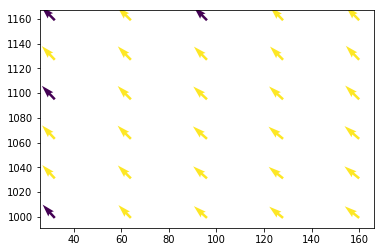

In [5]:
fig,ax = plt.subplots()
ax.quiver(x,y,u[0,:,:],v[0,:,:],chc[0,:,:])

In [6]:
def pod_modes(u,v,n_modes=None,method='snapshot',reconstruction=None,modes_list=None):
    """ estimates POD modes of a 2D vector field using a direct or a snapshot methods 
    Arguments:
        u,v : numpy arrays of N x r  x c shape, where N is the number of files (PIV maps)
        n_modes : number of modes to reconstruct, default=None, means all the relevant modes, 
            for the snapshot method it is a number of PIV maps, N. For the direct method the 
            possible number of modes is larger but useful ones are only N
        method : 'snapshot' or 'direct'
        reconstruction : None/'flow'/'weight'/'no_weight', if 'flow', the PIV maps are 
                reconstructed using 'modes_list'. if 'weight', the 'modes_list' is 
                used for the reconstruction or for the multimode presentation weighted by 
                the respective eigenvalues, 'no_weight' is a sum of modes without weights.
    """
    N = len(u)
    r,c = u[0].shape

    # read data and rearrange in columns
    len1 = r*c

    U = np.zeros((len1*2,N)) # r*c*3 length of the vector

    # stack [u,v] together in columns
    for i in range(N):
        U[:len1,i] = u[i,:,:].flatten()
        U[len1:,i] = v[i,:,:].flatten()

    # fluctuations
    Umean = np.mean(U,axis=1)
    Uf = U - Umean[:,np.newaxis]

    if method is 'snapshot': # small size as number of snapshots
        R = np.dot(Uf.T,Uf)  # R = Uf.T@Uf equivalent expression
    elif method is 'direct': # large size as size of the PIV map
        R = np.dot(Uf,Uf.T)  # or R  = Uf@Uf.T

    # print(R.shape)

    D,V = np.linalg.eigh(R)

    # check consistency 
    assert (np.abs(np.dot(R,V) - np.dot(V,np.diag(D))).max() < 1e-11)

    _D = D/N
    I = np.argsort(_D)[::-1]
    L = _D[I]

    if n_modes is None:
        n_modes = np.min([N,D.shape[0]]) # all relevant
        
    Erel = np.cumsum(L/np.sum(L))

    if method is 'snapshot':
        S = np.sqrt(D)# np.abs(D))
        S = S[I]
        V = V[:,I]
        a = np.diag(S[:n_modes])@V[:,:n_modes].T
        phi = -1*Uf@V[:,:n_modes]@np.diag(1./S[:n_modes])
    elif method is 'direct':
        phi = V[:,I]
        a = np.dot(Uf.T,phi[:,:n_modes]).T
        phi = phi[:,:n_modes].real

    umodes,vmodes = np.zeros((r,c,n_modes)),np.zeros((r,c,n_modes))
    for i in range(n_modes):
        umodes[:,:,i] = phi[:len1,i].reshape(r,c)
        vmodes[:,:,i] = phi[len1:,i].reshape(r,c)
        
    # multi-mode reconstruction
    if modes_list is None:
        modes_list = range(n_modes)
            
    # reconstruction of PIV maps
    if reconstruction is 'flow':
        ur = np.zeros_like(u)
        vr = np.zeros_like(v)
        for i in range(N):
            _phi = np.dot(phi[modes_list,i],a[modes_list,i]) + Umean
            ur[i,:,:] = _phi[:len1].reshape(r,c)
            vr[i,:,:] = _phi[len1:].reshape(r,c)
            
        return umodes,vmodes,Erel,ur,vr
    # create a multi-mode presentation
    elif reconstruction is 'weight':
        ur = umodes[:,:,modes_list[0]] * L[modes_list[0]]
        vr = vmodes[:,:,modes_list[0]] * L[modes_list[0]]
        for m in modes_list[1:]:
            ur += umodes[:,:,m] * L[m]
            vr += vmodes[:,:,m] * L[m]
        return umodes,vmodes,Erel,ur,vr
    # create a multi-mode presentation
    elif reconstruction is 'no_weight':
        ur = umodes[:,:,modes_list[0]]
        vr = vmodes[:,:,modes_list[0]]
        for m in modes_list[1:]:
            ur += umodes[:,:,m] 
            vr += vmodes[:,:,m]
        return umodes,vmodes,Erel,ur,vr 
    else:
        return umodes,vmodes,Erel

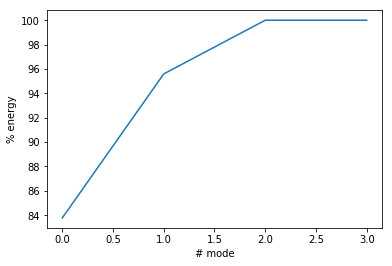

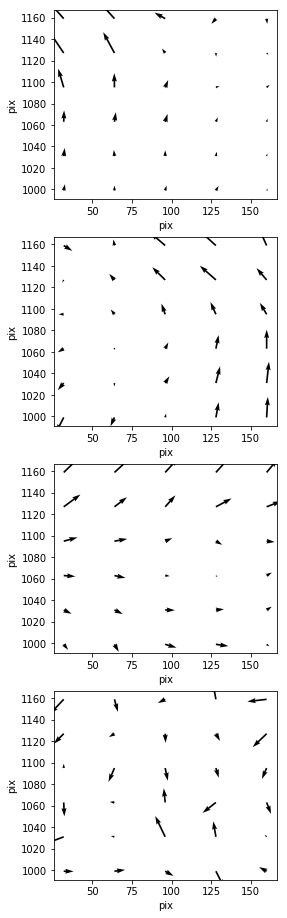

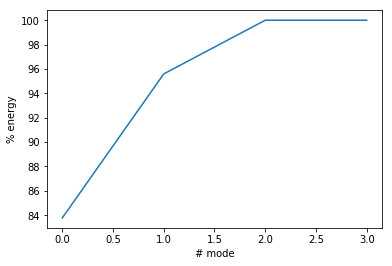

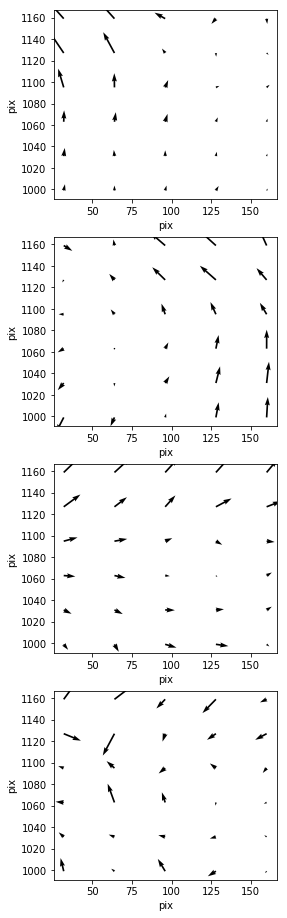

In [7]:
N = len(u)
for method in ['snapshot','direct']:
    umodes,vmodes,Erel = pod_modes(u,v,n_modes=None, method=method)

    plt.figure()
    plt.plot(Erel[:N]*100)
    plt.ylabel('% energy')
    plt.xlabel('# mode')

    fig,ax = plt.subplots(N,1,figsize=(4,16))
    for i in range(N):
        ax[i].quiver(x,y,umodes[:,:,i],vmodes[:,:,i])
        ax[i].set_xlabel('pix')
        ax[i].set_ylabel('pix')

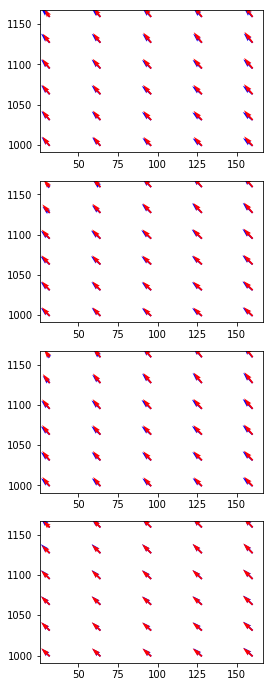

In [8]:
# multi-mode reconstruction
umodes,vmodes,Erel,ur,vr = pod_modes(u,v,n_modes=None, method='snapshot',\
                                      reconstruction='flow',modes_list=[0,1])
fig,ax = plt.subplots(N,1,figsize=(4,12))
for i in range(N):
    ax[i].quiver(x,y,u[i,:,:],v[i,:,:],color='b')
    ax[i].quiver(x,y,ur[i,:,:],vr[i,:,:],color='r')

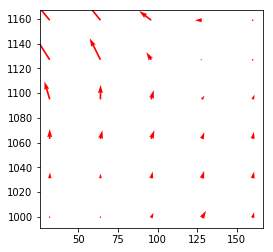

In [9]:
# multi-mode reconstruction
umodes,vmodes,Erel,ur,vr = pod_modes(u,v,n_modes=None, method='snapshot',\
                                      reconstruction='weight',modes_list=[0,1,2])
fig,ax = plt.subplots(figsize=(4,4))
ax.quiver(x,y,ur,vr,color='r')

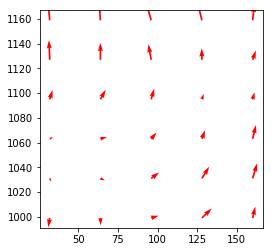

In [10]:
# multi-mode reconstruction
umodes,vmodes,Erel,ur,vr = pod_modes(u,v,n_modes=None, method='snapshot',\
                                      reconstruction='no_weight',modes_list=[0,1,2])
fig,ax = plt.subplots(figsize=(4,4))
ax.quiver(x,y,ur,vr,color='r')